# Movie lens data engineering

In [1]:
MOVIE_LENS_DATA_PATH = './data/ml-25m/'

In [2]:
!ls $MOVIE_LENS_DATA_PATH

README.txt	   links.csv		    ratings.csv
genome-scores.csv  movies.csv		    ratings_imdbId.csv
genome-tags.csv    movies_preprocessed.csv  tags.csv


In [3]:
import pandas as pd
import numpy as np

In [4]:
movies = pd.read_csv(MOVIE_LENS_DATA_PATH+"movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = pd.read_csv(MOVIE_LENS_DATA_PATH+"ratings.csv")

In [6]:
!head ./data/ml-25m/ratings.csv

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [8]:
numeric_features = []
cat_features = []

## Extract movie statistics


### Movies ave rating & numbers of ratings

In [9]:
movies_num_ratings = pd.DataFrame(ratings.groupby('movieId').agg({'userId': ['count'],
                                                                  'rating': ['mean']}))

In [10]:
movies_num_ratings.columns = ["_".join(x) for x in movies_num_ratings.columns.ravel()]

In [11]:
movies_num_ratings.head()

,userId_count,rating_mean
movieId,,
1,57309,3.893708
2,24228,3.251527
3,11804,3.142028
4,2523,2.853547
5,11714,3.058434


In [12]:
movies = movies.join(movies_num_ratings, on = 'movieId')

In [13]:
movies.head()

,movieId,title,genres,userId_count,rating_mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434


In [14]:
numeric_features += ['userId_count', 'rating_mean']

## Extract movie year

In [15]:
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)

movies['year_cat'] = movies['year']

In [16]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0


In [17]:
numeric_features += ['year']
cat_features += ['year_cat'] # encode year as both numeric and cat?

## Movies genres

In [18]:
genres = set()

In [19]:
for g in movies['genres']:
    genres = genres.union(set(g.split('|')))

In [20]:
genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [21]:
len(genres)

20

In [22]:
cat_features += ['genres']

## Tags & genres: using TF-IDF and SVD

In [23]:
tags = pd.read_csv(MOVIE_LENS_DATA_PATH+"tags.csv")
# create a mixed dataframe of movies title, genres 
# and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,791.0,Owned,1.515175e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1048.0,imdb top 250,1.172144e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1361.0,Pixar,1.216146e+09


In [24]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                             lambda x: "%s" % ' '.join(x)))


In [25]:
movies_meta = pd.merge(movies, mixed, on='movieId', how='left')
movies_meta['metadata'] = movies_meta[['tag', 'genres']].apply(
                             lambda x: ' '.join(x), axis = 1)
movies_meta[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Owned imdb top 250 Pixar Pixar time travel chi...
1,2,Jumanji (1995),Robin Williams time travel fantasy based on ch...
2,3,Grumpier Old Men (1995),funny best friend duringcreditsstinger fishing...


### TF-IDF vectorizer

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_meta['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies_meta['movieId'].tolist())
print(tfidf_df.shape)

(62423, 35768)


In [27]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,35758,35759,35760,35761,35762,35763,35764,35765,35766,35767
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
len(tfidf.vocabulary_)

35768

In [29]:
!mkdir ./assets

In [30]:
import pickle

with open('./assets/movie-lens-tf-idf.pkl', 'wb') as f:
    pickle.dump({"tfidf": tfidf}, f)

#### TF-IDF Transform new movie

In [31]:
new_movie_feat = tfidf.transform(['cartoon'])

In [32]:
new_movie_feat

<1x35768 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

### SVD on content

In [33]:
NUM_LATENT_FACTOR = 10

# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=NUM_LATENT_FACTOR)
latent_matrix = svd.fit_transform(tfidf_df)
 
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()


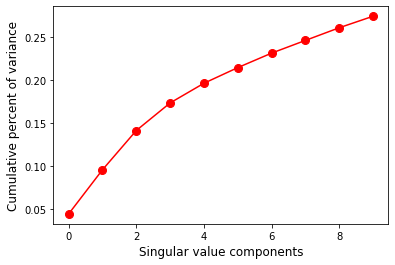

In [34]:
import matplotlib.pyplot as plt
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [35]:
latent_matrix_1_df = pd.DataFrame(latent_matrix,
                                  index=movies_meta['movieId'].tolist())

In [36]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9
1,0.040733,0.000289,0.051062,0.002788,0.028937,0.011539,-0.090286,0.292956,-0.019774,0.198858
2,0.013167,0.000391,0.005222,0.001947,0.024571,0.013686,-0.019495,0.082420,-0.009482,0.016160
3,0.025698,-0.000123,0.028008,-0.000756,0.000759,0.033750,0.006380,-0.000772,-0.004227,0.001202
4,0.099710,-0.001299,0.028951,-0.003483,-0.008626,0.069817,0.014665,-0.002576,-0.008467,0.005047
5,0.059480,-0.000102,0.083626,-0.001705,0.003621,-0.008397,-0.001660,0.017340,0.002922,0.003235


In [37]:
latent_matrix_1_df.set_axis(['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)], axis='columns', inplace=True)
latent_matrix_1_df.columns

Index(['SVD_latent_0', 'SVD_latent_1', 'SVD_latent_2', 'SVD_latent_3',
       'SVD_latent_4', 'SVD_latent_5', 'SVD_latent_6', 'SVD_latent_7',
       'SVD_latent_8', 'SVD_latent_9'],
      dtype='object')

In [38]:
latent_matrix_1_df['movieId'] = latent_matrix_1_df.index

In [39]:
latent_matrix_1_df.head()

,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,SVD_latent_6,SVD_latent_7,SVD_latent_8,SVD_latent_9,movieId
1,0.040733,0.000289,0.051062,0.002788,0.028937,0.011539,-0.090286,0.292956,-0.019774,0.198858,1
2,0.013167,0.000391,0.005222,0.001947,0.024571,0.013686,-0.019495,0.082420,-0.009482,0.016160,2
3,0.025698,-0.000123,0.028008,-0.000756,0.000759,0.033750,0.006380,-0.000772,-0.004227,0.001202,3
4,0.099710,-0.001299,0.028951,-0.003483,-0.008626,0.069817,0.014665,-0.002576,-0.008467,0.005047,4
5,0.059480,-0.000102,0.083626,-0.001705,0.003621,-0.008397,-0.001660,0.017340,0.002922,0.003235,5


In [40]:
movies = movies.merge(latent_matrix_1_df, on='movieId', how='left')

In [41]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,SVD_latent_6,SVD_latent_7,SVD_latent_8,SVD_latent_9
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,0.040733,0.000289,0.051062,0.002788,0.028937,0.011539,-0.090286,0.292956,-0.019774,0.198858
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0,0.013167,0.000391,0.005222,0.001947,0.024571,0.013686,-0.019495,0.082420,-0.009482,0.016160
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0,0.025698,-0.000123,0.028008,-0.000756,0.000759,0.033750,0.006380,-0.000772,-0.004227,0.001202
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0,0.099710,-0.001299,0.028951,-0.003483,-0.008626,0.069817,0.014665,-0.002576,-0.008467,0.005047
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0.059480,-0.000102,0.083626,-0.001705,0.003621,-0.008397,-0.001660,0.017340,0.002922,0.003235


In [42]:
numeric_features += ['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)]

In [43]:
numeric_features

['userId_count',
 'rating_mean',
 'year',
 'SVD_latent_0',
 'SVD_latent_1',
 'SVD_latent_2',
 'SVD_latent_3',
 'SVD_latent_4',
 'SVD_latent_5',
 'SVD_latent_6',
 'SVD_latent_7',
 'SVD_latent_8',
 'SVD_latent_9']

#### SVD transform new movie

In [44]:
latent_matrix = svd.transform(new_movie_feat)

In [45]:
latent_matrix.shape

(1, 10)

In [46]:
with open('./assets/svd.pkl', 'wb') as f:
    pickle.dump({"svd": svd}, f)

##  Popularity score

https://www.kaggle.com/rounakbanik/movie-recommender-systems?

Weighted Rating (WR) = (v/(v+m).R)+(m/(v+m).C)

where,

    v is the number of votes for the movie
    m is the minimum votes required to be listed in the chart
    R is the average rating of the movie
    C is the mean vote across the whole report


In [47]:
C = ratings['rating'].mean()

In [48]:
C

3.533854451353085

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [49]:
m = movies_num_ratings['userId_count'].quantile(0.95)
m

1503.3999999999942



Therefore, to qualify to be considered for the chart, a movie has to have at least 1503 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10. 2274 Movies qualify to be on our chart.


In [50]:
qualified = movies[movies['userId_count'] >= m]

In [51]:
qualified.shape

(2953, 17)

In [52]:
def weighted_rating(x):
    v = x['userId_count']
    R = x['rating_mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [53]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [55]:
qualified.head(100)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,SVD_latent_6,SVD_latent_7,SVD_latent_8,SVD_latent_9,wr
314,318,"Shawshank Redemption, The (1994)",Crime|Drama,81482.0,4.413576,1994.0,1994.0,0.038376,0.000371,-0.019880,0.001648,0.015151,0.000970,-0.009760,0.004189,0.006340,0.001843,4.397639
840,858,"Godfather, The (1972)",Crime|Drama,52498.0,4.324336,1972.0,1972.0,0.032702,0.000421,-0.011775,0.002677,0.056108,0.007822,-0.056588,-0.030222,0.015745,0.011212,4.302329
49,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,55366.0,4.284353,1995.0,1995.0,0.020883,0.000365,-0.005520,0.001802,0.075711,0.002229,-0.029057,-0.035756,0.018881,0.036109,4.264513
1190,1221,"Godfather: Part II, The (1974)",Crime|Drama,34188.0,4.261759,1974.0,1974.0,0.020465,0.000722,-0.005198,0.003065,0.044568,0.006276,-0.043611,-0.021463,0.017797,0.006850,4.231098
522,527,Schindler's List (1993),Drama|War,60411.0,4.247579,1993.0,1993.0,0.034736,0.001773,-0.017766,0.008450,0.011429,0.011837,-0.016868,0.021563,0.001507,-0.018445,4.230248
2867,2959,Fight Club (1999),Action|Crime|Drama|Thriller,58773.0,4.228311,1999.0,1999.0,0.056161,-0.000138,0.070963,-0.000067,0.025588,-0.009367,-0.016011,-0.003074,0.003130,-0.005633,4.210990
1164,1193,One Flew Over the Cuckoo's Nest (1975),Drama,36058.0,4.218662,1975.0,1975.0,0.033359,0.000119,-0.018500,0.001298,0.002573,0.000451,0.002562,0.008823,0.004446,0.000217,4.191252
883,904,Rear Window (1954),Mystery|Thriller,20162.0,4.237948,1954.0,1954.0,0.020152,0.000388,-0.010706,0.001808,0.106417,-0.000779,0.006691,-0.041240,0.026251,0.069697,4.189089
1173,1203,12 Angry Men (1957),Drama,16569.0,4.243014,1957.0,1957.0,0.060310,-0.000790,-0.036009,0.000506,0.006395,-0.006528,-0.010209,-0.001335,0.001555,0.002463,4.184021
1930,2019,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama,13367.0,4.254769,1954.0,1954.0,0.015977,0.000493,-0.005322,0.001409,0.025025,0.009143,-0.037121,0.010755,-0.001900,-0.034955,4.181885


## Break genres into one-hot columns

In [56]:
for g in genres:
    movies[g] = 0

In [57]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,War,Animation,Crime,Mystery,Western,(no genres listed),Fantasy,Action,Drama,Horror
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,0.040733,0.000289,0.051062,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0,0.013167,0.000391,0.005222,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0,0.025698,-0.000123,0.028008,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0,0.099710,-0.001299,0.028951,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0.059480,-0.000102,0.083626,...,0,0,0,0,0,0,0,0,0,0


In [58]:
from tqdm import tqdm

for i, row in tqdm(movies.iterrows(), total=len(movies)):
    try:
        row_genres = row['genres'].split('|')
        for g in row_genres:
            movies.at[i, g] = 1
    except:
        pass

100%|██████████| 62423/62423 [00:09<00:00, 6559.04it/s]


In [59]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,War,Animation,Crime,Mystery,Western,(no genres listed),Fantasy,Action,Drama,Horror
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,0.040733,0.000289,0.051062,...,0,1,0,0,0,0,1,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0,0.013167,0.000391,0.005222,...,0,0,0,0,0,0,1,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0,0.025698,-0.000123,0.028008,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0,0.099710,-0.001299,0.028951,...,0,0,0,0,0,0,0,0,1,0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0.059480,-0.000102,0.083626,...,0,0,0,0,0,0,0,0,0,0


In [60]:
cat_features += [g for g in genres]

In [61]:
cat_features

['year_cat',
 'genres',
 'Children',
 'Romance',
 'Comedy',
 'Musical',
 'IMAX',
 'Sci-Fi',
 'Documentary',
 'Adventure',
 'Film-Noir',
 'Thriller',
 'War',
 'Animation',
 'Crime',
 'Mystery',
 'Western',
 '(no genres listed)',
 'Fantasy',
 'Action',
 'Drama',
 'Horror']

### Popularity score per genre

In [62]:
def build_chart(genre, percentile=0.85):
    df = movies[movies[genre] == 1] #filter out genre
    
    C = ratings['rating'].mean()
    m = movies_num_ratings['userId_count'].quantile(percentile)
    
    qualified = df[df['userId_count'] >= m]
    qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
    
    qualified = qualified.sort_values('%s_wr'%genre, ascending=False).head(250)
    qualified.reset_index(inplace=True, drop=True)
    qualified['%s_rank'%genre] = qualified.index
    
    return qualified

In [63]:
Romance_chart = build_chart('Romance')
Romance_chart.head(15)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,Crime,Mystery,Western,(no genres listed),Fantasy,Action,Drama,Horror,Romance_wr,Romance_rank
0,912,Casablanca (1942),Drama|Romance,26890.0,4.206564,1942.0,1942.0,0.057519,0.001180,-0.005128,...,0,0,0,0,0,0,1,0,4.170945,0
1,908,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,16850.0,4.196617,1959.0,1959.0,0.017250,0.000519,-0.005695,...,0,1,0,0,0,1,0,0,4.142328,1
2,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,23976.0,4.154342,1997.0,1997.0,0.042664,0.001530,0.032907,...,0,0,0,0,0,0,1,0,4.117730,2
3,44555,"Lives of Others, The (Das leben der Anderen) (...",Drama|Romance|Thriller,9177.0,4.200392,2006.0,2006.0,0.034744,0.000763,-0.016692,...,0,0,0,0,0,0,1,0,4.106569,3
4,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,37863.0,4.129097,1987.0,1987.0,0.082517,-0.000160,0.077415,...,0,0,0,0,1,1,0,0,4.106365,4
5,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,7368.0,4.206501,1950.0,1950.0,0.055630,0.002056,0.035987,...,0,0,0,0,0,0,1,0,4.092510,5
6,2858,American Beauty (1999),Drama|Romance,53689.0,4.107340,1999.0,1999.0,0.110785,-0.000759,0.159005,...,0,0,0,0,0,0,1,0,4.091719,6
7,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance,34320.0,4.101282,2001.0,2001.0,0.052364,0.000277,0.037333,...,0,0,0,0,0,0,0,0,4.077469,7
8,903,Vertigo (1958),Drama|Mystery|Romance|Thriller,15945.0,4.120822,1958.0,1958.0,0.010074,0.000697,-0.001061,...,0,1,0,0,0,0,1,0,4.070247,8
9,1704,Good Will Hunting (1997),Drama|Romance,38947.0,4.074935,1997.0,1997.0,0.013639,0.000080,-0.006489,...,0,0,0,0,0,0,1,0,4.054825,9


In [64]:
for genre in tqdm(genres):
     chart = build_chart(genre)
     movies = movies.merge(chart[["movieId", "%s_wr"%genre, "%s_rank"%genre]], on='movieId', how='left')

    

  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
  5%|▌         | 1/20 [00:00<00:04,  3.86it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
 10%|█         | 2/20 [00:00<00:04,  3.72it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [65]:
movies.fillna(0, inplace=True)

In [66]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,(no genres listed)_wr,(no genres listed)_rank,Fantasy_wr,Fantasy_rank,Action_wr,Action_rank,Drama_wr,Drama_rank,Horror_wr,Horror_rank
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,0.040733,0.000289,0.051062,...,0.0,0.0,3.884509,19.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0,0.013167,0.000391,0.005222,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0,0.025698,-0.000123,0.028008,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0,0.099710,-0.001299,0.028951,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0.059480,-0.000102,0.083626,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
movies.shape

(62423, 77)

In [68]:
numeric_features += ["%s_wr"%g for g in genres]
numeric_features += ["%s_rank"%g for g in genres]

In [69]:
numeric_features

['userId_count',
 'rating_mean',
 'year',
 'SVD_latent_0',
 'SVD_latent_1',
 'SVD_latent_2',
 'SVD_latent_3',
 'SVD_latent_4',
 'SVD_latent_5',
 'SVD_latent_6',
 'SVD_latent_7',
 'SVD_latent_8',
 'SVD_latent_9',
 'Children_wr',
 'Romance_wr',
 'Comedy_wr',
 'Musical_wr',
 'IMAX_wr',
 'Sci-Fi_wr',
 'Documentary_wr',
 'Adventure_wr',
 'Film-Noir_wr',
 'Thriller_wr',
 'War_wr',
 'Animation_wr',
 'Crime_wr',
 'Mystery_wr',
 'Western_wr',
 '(no genres listed)_wr',
 'Fantasy_wr',
 'Action_wr',
 'Drama_wr',
 'Horror_wr',
 'Children_rank',
 'Romance_rank',
 'Comedy_rank',
 'Musical_rank',
 'IMAX_rank',
 'Sci-Fi_rank',
 'Documentary_rank',
 'Adventure_rank',
 'Film-Noir_rank',
 'Thriller_rank',
 'War_rank',
 'Animation_rank',
 'Crime_rank',
 'Mystery_rank',
 'Western_rank',
 '(no genres listed)_rank',
 'Fantasy_rank',
 'Action_rank',
 'Drama_rank',
 'Horror_rank']

In [70]:
with open('./assets/features.pkl', 'wb') as f:
    pickle.dump({"numeric_features": numeric_features, 'cat_features': cat_features }, f)


# Using IMDB ID

In [71]:
links = pd.read_csv('/home/vinhngx/vinh-all-data/Recommender-movie/data/ml-25m/links.csv', dtype={'imdbId':str, 'tmdbId': str})

In [72]:
#movies = movies.merge(links, on='movieId', how='left')

In [73]:
#movies.head()

In [74]:
#movies.to_csv(MOVIE_LENS_DATA_PATH+"movies_preprocessed.csv", index=False)

# Reading back data

In [75]:
import pickle
import pandas as pd
import numpy as np

with open('./assets/features.pkl', 'rb') as f:
    feat = pickle.load(f)
    num_feats= feat['numeric_features']
    cat_feats= feat['cat_features']


In [76]:
cat_feats

['year_cat',
 'genres',
 'Children',
 'Romance',
 'Comedy',
 'Musical',
 'IMAX',
 'Sci-Fi',
 'Documentary',
 'Adventure',
 'Film-Noir',
 'Thriller',
 'War',
 'Animation',
 'Crime',
 'Mystery',
 'Western',
 '(no genres listed)',
 'Fantasy',
 'Action',
 'Drama',
 'Horror']

In [77]:
dtypes = {num_feat: np.float for num_feat in num_feats}

In [78]:
dtypes.update({cat_feat: str for cat_feat in cat_feats})

In [79]:
MOVIE_LENS_DATA_PATH

'./data/ml-25m/'

In [80]:
movie_data = pd.read_csv(MOVIE_LENS_DATA_PATH+"movies_preprocessed.csv", dtype=dtypes)

In [81]:
movie_data.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,Comedy_wr,Comedy_rank,Western_wr,Western_rank,(no genres listed)_wr,(no genres listed)_rank,Musical_wr,Musical_rank,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,0.040733,0.000288,0.051061,...,3.884509,58.0,0.0,0.0,0.0,0.0,0.0,0.0,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0,0.013167,0.000391,0.005223,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0,0.025699,-0.000123,0.028008,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0,0.099711,-0.001300,0.028950,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0.059480,-0.000102,0.083627,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113041,11862.0


In [82]:
movie_data.dtypes

movieId                      int64
title                       object
genres                      object
userId_count               float64
rating_mean                float64
year                       float64
year_cat                    object
SVD_latent_0               float64
SVD_latent_1               float64
SVD_latent_2               float64
SVD_latent_3               float64
SVD_latent_4               float64
SVD_latent_5               float64
SVD_latent_6               float64
SVD_latent_7               float64
SVD_latent_8               float64
SVD_latent_9               float64
Thriller                    object
Crime                       object
Animation                   object
Adventure                   object
Action                      object
Mystery                     object
Romance                     object
Drama                       object
Fantasy                     object
IMAX                        object
Sci-Fi                      object
Documentary         

# Merge with rating data

In [83]:
#too memory intensive
#ratings = ratings.merge(movie_data, how='left', on='movieId')

In [84]:
#ratings = ratings.merge(links, how='left', on = 'movieId')

In [85]:
#ratings.head()

In [86]:
#ratings['movieId'] = ratings['imdbId'] 

In [87]:
#ratings.dtypes

In [88]:
#ratings.head()

In [89]:
#ratings.to_csv(MOVIE_LENS_DATA_PATH+"ratings_imdbId.csv", index=False)

In [90]:
#ratings.shape

## Write a small dataset for DLRM PyT prep

In [91]:
movie_data.shape

(62423, 79)

In [92]:
movie_data['userId'] = np.arange(62423)


In [93]:
movie_data['rating'] = np.random.randint(1, 5,  (movie_data.shape[0]))

In [94]:
movie_data.shape

(62423, 81)

In [95]:
movie_data.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,Western_wr,Western_rank,(no genres listed)_wr,(no genres listed)_rank,Musical_wr,Musical_rank,imdbId,tmdbId,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,0.040733,0.000288,0.051061,...,0.0,0.0,0.0,0.0,0.0,0.0,114709,862.0,0,4
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0,0.013167,0.000391,0.005223,...,0.0,0.0,0.0,0.0,0.0,0.0,113497,8844.0,1,3
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0,0.025699,-0.000123,0.028008,...,0.0,0.0,0.0,0.0,0.0,0.0,113228,15602.0,2,2
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0,0.099711,-0.001300,0.028950,...,0.0,0.0,0.0,0.0,0.0,0.0,114885,31357.0,3,1
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0.059480,-0.000102,0.083627,...,0.0,0.0,0.0,0.0,0.0,0.0,113041,11862.0,4,2


In [96]:
cat_features = ['userId', 'imdbId'] + cat_feats  
numeric_features = num_feats

In [97]:
label = ['rating']
dummy_data = movie_data[label+numeric_features+cat_features]

In [98]:
numeric_features

['userId_count',
 'rating_mean',
 'year',
 'SVD_latent_0',
 'SVD_latent_1',
 'SVD_latent_2',
 'SVD_latent_3',
 'SVD_latent_4',
 'SVD_latent_5',
 'SVD_latent_6',
 'SVD_latent_7',
 'SVD_latent_8',
 'SVD_latent_9',
 'Children_wr',
 'Romance_wr',
 'Comedy_wr',
 'Musical_wr',
 'IMAX_wr',
 'Sci-Fi_wr',
 'Documentary_wr',
 'Adventure_wr',
 'Film-Noir_wr',
 'Thriller_wr',
 'War_wr',
 'Animation_wr',
 'Crime_wr',
 'Mystery_wr',
 'Western_wr',
 '(no genres listed)_wr',
 'Fantasy_wr',
 'Action_wr',
 'Drama_wr',
 'Horror_wr',
 'Children_rank',
 'Romance_rank',
 'Comedy_rank',
 'Musical_rank',
 'IMAX_rank',
 'Sci-Fi_rank',
 'Documentary_rank',
 'Adventure_rank',
 'Film-Noir_rank',
 'Thriller_rank',
 'War_rank',
 'Animation_rank',
 'Crime_rank',
 'Mystery_rank',
 'Western_rank',
 '(no genres listed)_rank',
 'Fantasy_rank',
 'Action_rank',
 'Drama_rank',
 'Horror_rank']

In [99]:
dummy_data[label+numeric_features].astype(np.float)

,rating,userId_count,rating_mean,year,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,...,War_rank,Animation_rank,Crime_rank,Mystery_rank,Western_rank,(no genres listed)_rank,Fantasy_rank,Action_rank,Drama_rank,Horror_rank
0,4.0,57309.0,3.893708,1995.0,0.040733,2.883620e-04,0.051061,0.002788,0.028925,0.011604,...,0.0,20.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0
1,3.0,24228.0,3.251527,1995.0,0.013167,3.912218e-04,0.005223,0.001950,0.024602,0.013540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,11804.0,3.142028,1995.0,0.025699,-1.233279e-04,0.028008,-0.000756,0.000757,0.033765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2523.0,2.853547,1995.0,0.099711,-1.299670e-03,0.028950,-0.003481,-0.008644,0.069912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,11714.0,3.058434,1995.0,0.059480,-1.018372e-04,0.083627,-0.001703,0.003636,-0.008458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,24588.0,3.854909,1995.0,0.024168,2.655133e-04,-0.004543,0.001592,0.081778,0.018147,...,0.0,0.0,75.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0
6,3.0,12132.0,3.363666,1995.0,0.065279,-2.996950e-07,0.028355,-0.001667,-0.003678,0.155513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1344.0,3.114583,1995.0,0.014114,5.063206e-04,0.004627,0.002371,0.017024,0.015152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3.0,3711.0,2.992051,1995.0,0.010036,-3.451737e-05,-0.000814,0.000546,0.036972,0.012236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3.0,28265.0,3.421458,1995.0,0.008672,1.905119e-04,-0.001231,0.001091,0.036973,0.006999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
dummy_data = dummy_data.values

In [101]:
dummy_data.shape

(62423, 78)

In [102]:
len(dummy_data[1,:])

78

In [103]:
dummy_data[1,:]

array([3, 24228.0, 3.2515271586594023, 1995.0, 0.0131666860292309,
       0.00039122180765856365, 0.0052229636955399865, 0.00194991484431798,
       0.024602408462604045, 0.01354019340147117, -0.019585426315494543,
       0.08226378833269103, -0.009347090367156134, 0.016652667767957968,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 1, 113497, '1995.0', 'Adventure|Children|Fantasy', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '0', '0', '0'], dtype=object)

In [104]:
def write_DLRM_data(data, filename='dlrm_data.tsv'):
    print("Writing %d samples"%data.shape[0], filename)
    with open(filename, 'wt') as f:
        for i in tqdm(range(data.shape[0])):
            str = '%f'%data[i,0]
            for j in range(len(numeric_features)):
                str += '\t%f'%data[i,1+j]
            for j in range(len(cat_features)):
                str += '\t%s'%data[i,1+len(numeric_features)+j]
            f.write('%s\n'%(str)) #label, numeric feat., cat feat., userID, itemID

In [105]:
len(numeric_features)

53

In [106]:
len(cat_features)

24

In [107]:
cat_features

['userId',
 'imdbId',
 'year_cat',
 'genres',
 'Children',
 'Romance',
 'Comedy',
 'Musical',
 'IMAX',
 'Sci-Fi',
 'Documentary',
 'Adventure',
 'Film-Noir',
 'Thriller',
 'War',
 'Animation',
 'Crime',
 'Mystery',
 'Western',
 '(no genres listed)',
 'Fantasy',
 'Action',
 'Drama',
 'Horror']

In [108]:
numeric_features

['userId_count',
 'rating_mean',
 'year',
 'SVD_latent_0',
 'SVD_latent_1',
 'SVD_latent_2',
 'SVD_latent_3',
 'SVD_latent_4',
 'SVD_latent_5',
 'SVD_latent_6',
 'SVD_latent_7',
 'SVD_latent_8',
 'SVD_latent_9',
 'Children_wr',
 'Romance_wr',
 'Comedy_wr',
 'Musical_wr',
 'IMAX_wr',
 'Sci-Fi_wr',
 'Documentary_wr',
 'Adventure_wr',
 'Film-Noir_wr',
 'Thriller_wr',
 'War_wr',
 'Animation_wr',
 'Crime_wr',
 'Mystery_wr',
 'Western_wr',
 '(no genres listed)_wr',
 'Fantasy_wr',
 'Action_wr',
 'Drama_wr',
 'Horror_wr',
 'Children_rank',
 'Romance_rank',
 'Comedy_rank',
 'Musical_rank',
 'IMAX_rank',
 'Sci-Fi_rank',
 'Documentary_rank',
 'Adventure_rank',
 'Film-Noir_rank',
 'Thriller_rank',
 'War_rank',
 'Animation_rank',
 'Crime_rank',
 'Mystery_rank',
 'Western_rank',
 '(no genres listed)_rank',
 'Fantasy_rank',
 'Action_rank',
 'Drama_rank',
 'Horror_rank']

In [109]:
!rm -rf /data/dlrm/
!mkdir -p /data/dlrm/criteo

from tqdm import tqdm
for i, data_arr in enumerate(np.array_split(dummy_data,24)):
    write_DLRM_data(data_arr, filename='/data/dlrm/criteo/day_%d'%i)

mkdir: cannot create directory ‘/data/dlrm’: No such file or directory
Writing 2601 samples /data/dlrm/criteo/day_0


FileNotFoundError: [Errno 2] No such file or directory: '/data/dlrm/criteo/day_0'

In [ ]:
data_arr[1, 54]

In [ ]:
!head -n 1 /data/dlrm/criteo/day_12

In [ ]:
x ="1.000000	7.000000	4.428571	1992.000000	0.013020	0.583846	-0.003132	-0.004821	-0.001696	-0.004281	-0.001753	-0.005728	-0.021785	0.004834	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	31212	480827	1992.0	(no genres listed)	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0"
t = x.split('\t')

In [ ]:
len(t)

In [ ]:
t[54]

In [ ]:
t[54]

In [ ]:
 all_columns_sorted = [f'_c{i}' for i in range(0, 78)]

In [ ]:
LABEL_COL = 0
INT_COLS = list(range(1, 1+53)) # 1 label, 53 numeric, 24 cat features
CAT_COLS = list(range(1+53, 1+53+24))

In [ ]:
CAT_COLS

# Prep

In [ ]:
!apt install psmisc


In [ ]:
%%bash
cd ./preproc
killall -9 java
bash ./prepare_dataset.sh

# 

In [ ]:
420670/323


# Check parquet

In [ ]:
!ls /data/dlrm/spark/output/models/54.parquet

In [ ]:
import pyarrow.parquet as pq

dataset = pq.ParquetDataset("/data/dlrm/spark/output/models/58.parquet")
table = dataset.read()
df = table.to_pandas()

In [ ]:
data_arr[:,58]

In [ ]:
df

In [ ]:
df['model_count'].sum()

In [ ]:
%run /workspace/dlrm/dlrm/scripts/main.py \
--mode train \
--dataset /data/dlrm/binary_dataset/ \
--num_numerical_features 53 \
--base_device cuda \
--lr 0.1 \
--embedding_type joint \
--epochs 10 \
--batch_size=8192 \
--save_checkpoint_path ./movie_lens_model